In [1]:
#Penguin calssifcation prediction via Azure ML

In [4]:
#import required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#loading the training dataset
df = pd.read_csv("penguin-data.csv")

In [5]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [15]:
#Lets take a random sample of 10 records
sample = df.sample(10)
sample

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
228,43.3,13.4,209.0,4400.0,2
94,36.2,17.3,187.0,3300.0,0
268,44.9,13.3,213.0,5100.0,2
71,39.7,18.4,190.0,3900.0,0
178,50.5,18.4,200.0,3400.0,1
236,42.0,13.5,210.0,4150.0,2
314,44.5,14.7,214.0,4850.0,2
185,51.0,18.8,203.0,4100.0,1
237,49.2,15.2,221.0,6300.0,2
216,43.5,18.1,202.0,3400.0,1


In [16]:
penguin_classes = ['Adelie','Chinstrap','Gentoo']
species_names = sample['Species'].apply(lambda x: penguin_classes[x])
sample['SpeciesName'] = species_names
sample

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species,SpeciesName
228,43.3,13.4,209.0,4400.0,2,Gentoo
94,36.2,17.3,187.0,3300.0,0,Adelie
268,44.9,13.3,213.0,5100.0,2,Gentoo
71,39.7,18.4,190.0,3900.0,0,Adelie
178,50.5,18.4,200.0,3400.0,1,Chinstrap
236,42.0,13.5,210.0,4150.0,2,Gentoo
314,44.5,14.7,214.0,4850.0,2,Gentoo
185,51.0,18.8,203.0,4100.0,1,Chinstrap
237,49.2,15.2,221.0,6300.0,2,Gentoo
216,43.5,18.1,202.0,3400.0,1,Chinstrap


In [17]:
#check rows wilth null values
df[df.isnull().any(axis=1)]

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
3,NaN,NaN,NaN,NaN,0
339,NaN,NaN,NaN,NaN,2


In [18]:
#since null are only two records, lets drop from the df
df=df.dropna()
#check for non-null rows
df.isnull().sum()

CulmenLength     0
CulmenDepth      0
FlipperLength    0
BodyMass         0
Species          0
dtype: int64

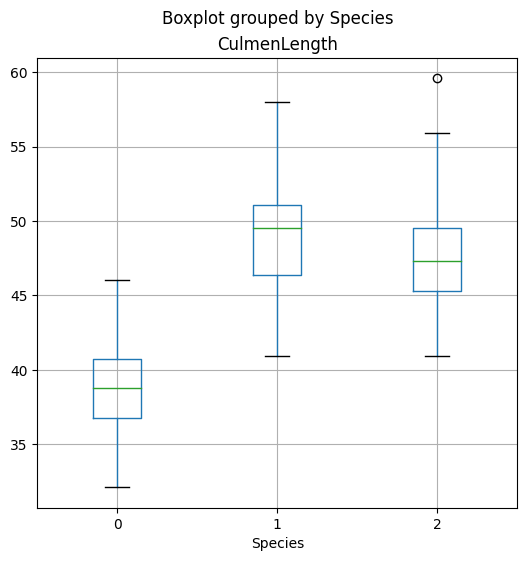

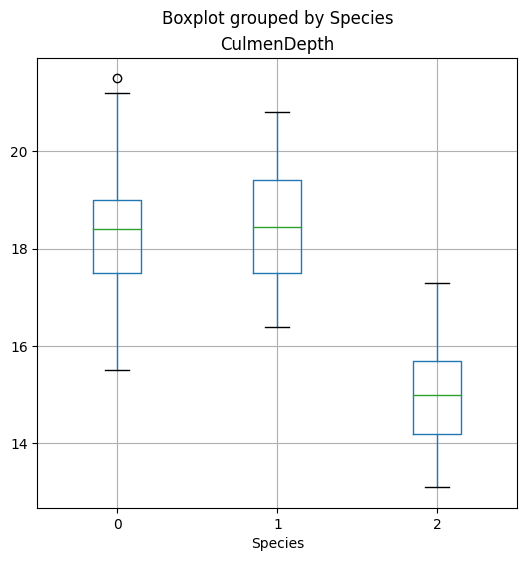

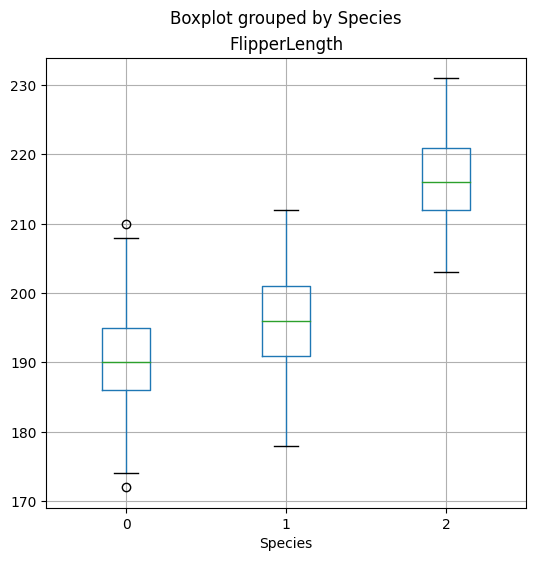

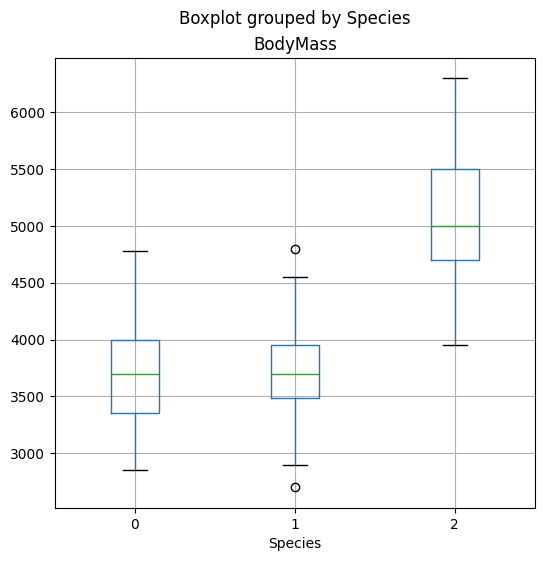

In [23]:
#Lets visualize the distribution of features for each species
%matplotlib inline

penguin_features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
penguin_label = 'Species'
for col in penguin_features:
    df.boxplot(column=col,by=penguin_label,figsize=(6,6))
    plt.title(col)

plt.show()

Species 0 (Adelie) tends to have a short, but deep culmen and generally has short flippers and a low body mass.

Species 1(Chinstrap) tends to have a long and deep culmen, medium length flipper, and a low body mass. 

Species 2 (Gentoo) tends to have medium length, thin culmen, with long flippers and a high body mass.

In [26]:
from sklearn.model_selection import train_test_split

penguin_X, penguin_y = df[penguin_features].values,df[penguin_label].values

x_train, x_test, y_train, y_test = train_test_split(penguin_X,penguin_y, test_size=0.3, random_state=0, stratify=penguin_y)

In [28]:
from sklearn.linear_model import LogisticRegression

reg=0.1

model = LogisticRegression(C=1/reg, solver='lbfgs', multi_class='auto', max_iter=10000).fit(x_train,y_train)
print(model)

LogisticRegression(C=10.0, max_iter=10000)


In [32]:
penguin_predictions = model.predict(x_test)

df_predictions = pd.DataFrame({
    'Predicted label':penguin_predictions, 
    'Actual label':y_test
})
df_predictions.head(5)

,Predicted label,Actual label
0,0,0
1,2,2
2,2,2
3,2,2
4,0,0


In [34]:
from sklearn.metrics import accuracy_score, classification_report
print (classification_report(y_test, penguin_predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.95      1.00      0.98        21
           2       1.00      1.00      1.00        37

    accuracy                           0.99       103
   macro avg       0.98      0.99      0.99       103
weighted avg       0.99      0.99      0.99       103



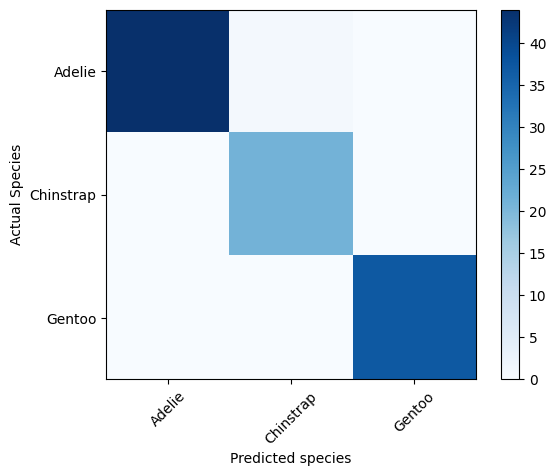

In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np
%matplotlib inline

c_matrix = confusion_matrix(y_test,penguin_predictions)
plt.imshow(c_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted species")
plt.ylabel("Actual Species")
plt.show()

In [39]:
x_new = np.array([[50.4, 15.3, 224, 5550]])
print ("New Sample : {}".format(x_new[0]))

penguin_pred = model.predict(x_new)[0]
print("Penguin class is: ", penguin_classes[penguin_pred])

New Sample : [  50.4   15.3  224.  5550. ]
Penguin class is:  Gentoo


In [40]:
import os, shutil

training_folder = 'penguin-training-folder'
os.makedirs(training_folder, exist_ok=True)

shutil.copy('penguin-data.csv', os.path.join(training_folder,"penguin-data.csv"))

'penguin-training-folder\\penguin-data.csv'

In [41]:
%%writefile $training_folder/train_penguins.py

import pandas as pd
import numpy as np
from matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import joblib
import os

from azureml.core import Run

run = Run.get_context()

print("Loading Data...")
penguins = pd.read_csv("penguin-data.csv")
penguins = penguins.dropna()
penguin_features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
penguin_label = 'Species'

penguin_X, penguin_y = df[penguin_features].values,df[penguin_label].values
x_train, x_test, y_train, y_test = train_test_split(penguin_X,penguin_y, test_size=0.3, random_state=0, stratify=penguin_y)

print("Training model...")
reg=0.1
model = LogisticRegression(C=1/reg, solver='lbfgs', multi_class='auto', max_iter=10000).fit(x_train,y_train)

penguin_predictions = model.predict(x_test)

#scores
run.log("Accuracy", np.float(accuracy_score(y_test, penguin_predictions)))
run.log("Precision", np.float(precision_score(y_test, penguin_predictions, average="macro")))
run.log("Recall", np.float(recall_score(y_test, penguin_predictions, average="macro")))


c_matrix = confusion_matrix(y_test,penguin_predictions)
fig = plt.figure(figsize=8,8)
plt.imshow(c_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
penguin_classes = ['Adelie','Chinstrap','Gentoo']
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted species")
plt.ylabel("Actual Species")
plt.show()
run.log_image(name = 'confusion_matrix', plot = fig)

os.makedirs('outputs',exist_ok=True)
joblib.dump(value=model, filename = 'outputs/penguin-model.pkl')


Writing penguin-training-folder/train_penguins.py


In [1]:
import azureml.core 
from azureml.core import Workspace

ws = Workspace.from_config()
print("Ready to use azure ML {} to work with {}".format(azureml.core.VERSION,ws.name))

In [1]:
from azureml.core import Environment, Experiment, ScriptRunConfig
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails

python_env = Environment("penguin-env")
packages = CondaDependencies.create(conda_packages=['scikit-learn','ipykernel','matplotlib','pandas','numpy','seaborn'],
                                    pip_packages=['azureml-sdk','pyarrow'])
python_env.python.conda_dependencies = packages

script_config = ScriptRunConfig(source_directory=training_folder,
                               script = 'train_penguins.py',
                                environment=python_env)

experiment_name = 'train-penguins'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

In [2]:
from azureml.core import Model

run.register_model(model_path='outputs/penguin-model.pkl',model_name='penguin-model',tags={'Context':'Penguin trainig project'}, properties={'Accuracy': run.get_metrics()})


In [2]:
from azureml.core.webservice import Webservice

service = Webservice(workspace=ws, name='penguin-service')
endpoint - service.scoring_uri
print(endpoint)

In [3]:
import requests
import json

x_new = [[41.5,18.5,201,4000],
         [46.1,13.2,211,4500]]

input_json = json.dumps({"data":x_new})

headers = {'Content-Type':'application/json'}

predictions = requests.post(endpoint, input_json, headers = headers)
predicted_classes = predictions.json()
penguin_classes = ['Adelie','Chinstrap','Gentoo']

for i in range(len(x_new)):
    print("Penguin {}".format(x_new[i]), penguin_classes[predicted_classes[i]])
